In [1]:
import os
import cv2
import random
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt

## Data Loading

In [2]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_img = [] #contains the images used for training the model
test_img = []
train_labels = [] #label of each image in x_train 
test_labels = []
TRAIN_PATH = '../input/brain-tumor-classification-mri/Training'
TEST_PATH = '../input/brain-tumor-classification-mri/Testing'
new_size = (255, 255)

for label in labels:
    img_dir = os.path.join(TRAIN_PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        img = cv2.resize(img, new_size)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)/255
        train_img.append(img)
        train_labels.append(label)
        
train_img = np.stack(train_img)
train_labels = np.stack(train_labels)

print("train_img shape : ", train_img.shape)
print("train_labels shape : ", train_labels.shape)

for label in labels:
    img_dir = os.path.join(TEST_PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        img = cv2.resize(img, new_size)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)/255
        test_img.append(img)
        test_labels.append(label)
        
test_img = np.stack(test_img)
test_labels = np.stack(test_labels)

print("test_img shape : ", test_img.shape)
print("test_labels shape : ", test_labels.shape)

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'pituitary_tumor': 2,
    'meningioma_tumor': 3
}

train_labels = np.array([class_map[label] for label in train_labels])
test_labels = np.array([class_map[label] for label in test_labels])

train_img shape :  (2870, 255, 255)
train_labels shape :  (2870,)
test_img shape :  (394, 255, 255)
test_labels shape :  (394,)


## Data pre-processing

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler #the Standard Scaler : X2 = (X1 - E(X1))/sqrt(Var(X1))
from sklearn.decomposition import PCA

train_img = train_img.reshape((train_img.shape[0], 255*255))
test_img = test_img.reshape((test_img.shape[0], 255*255))
S = StandardScaler()
X_train = S.fit_transform(train_img)
X_test = S.transform(test_img)
P = PCA(n_components = 100)
pca_train = P.fit_transform(X_train)
pca_test = P.transform(X_test)

In [4]:
data_train = np.hstack((pca_train, train_labels[:,None]))
data_test = np.hstack((pca_test, test_labels[:,None]))

all_data = np.vstack((data_train, data_test))
X = all_data[:,:-1]
y = all_data[:,-1]

# Multilayer Perceptron

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_validate, cross_val_score

In [6]:
# By default, MLP classifier has a single hidden layer with 100 neurons 
# and relu activation function
clf = MLPClassifier()
clf.fit(pca_train, train_labels)
print(clf.score(pca_train, train_labels))
print(clf.score(pca_test, test_labels))

1.0
0.7411167512690355


In [7]:
acc = cross_val_score(clf, pca_train, train_labels, cv=10).mean()
precision = cross_val_score(clf,pca_train, train_labels, cv=10, scoring='precision_weighted').mean()
recall = cross_val_score(clf, pca_train, train_labels, cv=10, scoring='recall_weighted').mean()
f1 = cross_val_score(clf,pca_train, train_labels, cv=10, scoring='f1_weighted').mean()
roc = cross_val_score(clf, pca_train, train_labels, cv=10, scoring='roc_auc_ovr_weighted').mean()


print("10-fold Accuracy = ", acc)
print("10-fold Precision = ", precision)
print("10-fold Recall = ", recall)
print("10-fold f1-score = ", f1)
print("10-fold roc score = ", roc)


10-fold Accuracy =  0.8547038327526133
10-fold Precision =  0.853771138588401
10-fold Recall =  0.8533101045296168
10-fold f1-score =  0.8489093704681459
10-fold roc score =  0.9479608678059444


The results are pretty good or above average, let's explore the hyperparameters tuning and make the multilayer perceptron more efficient

## Hyperparameters tuning

### Number of hidden layers change

In [8]:
#evaluation buffers

Architecture = []
Solver = []
Learning_rate = []
Activation = []
Solver = []
Accuracy = []
Precision = []
Recall = []
F1 = []
ROC = []


hidden_layers_sets = [
    (20,),
    (20,20,),
    (20, 20, 20,)
]

clfs = []

for nbHiddenLayers in hidden_layers_sets:
    clf = MLPClassifier(hidden_layer_sizes = nbHiddenLayers, max_iter = 1500)
    clf.fit(pca_train, train_labels)
    y_pred = clf.predict(pca_test)
    y_prob = clf.predict_proba(pca_test)
    acc = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred, average = "weighted")
    recall = recall_score(test_labels, y_pred, average = "weighted")
    f1 =f1_score(test_labels, y_pred, average = "weighted")
    roc = roc_auc_score(test_labels, y_prob, average = "weighted", multi_class = "ovr")
    clfs.append(clf)
    
    #acc = cross_val_score(clf, X, y, cv=10).mean()
    #precision = cross_val_score(clf,  X, y, cv=10, scoring='precision_weighted').mean()
    #recall = cross_val_score(clf,  X, y, cv=10, scoring='recall_weighted').mean()
    #f1 = cross_val_score(clf, X, y, cv=10, scoring='f1_weighted').mean()
    #roc = cross_val_score(clf,  X, y, cv=10, scoring='roc_auc_ovr_weighted').mean()

    print("\nSet of hidden layers: {}".format(nbHiddenLayers))
    #print("Score on test set: {}".format(clf.score(pca_test, test_labels)))
    print("Accuracy = ", acc)
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("f1-score = ", f1)
    print("Roc score = ", roc)
    
    Architecture.append(nbHiddenLayers)
    Solver.append("adam")
    Learning_rate.append(0.001)
    Activation.append("relu")
    Accuracy.append(acc)
    Precision.append(precision)
    Recall.append(recall)
    F1.append(f1)
    ROC.append(roc)


Set of hidden layers: (20,)
Accuracy =  0.7131979695431472
Precision =  0.7950801437481289
Recall =  0.7131979695431472
f1-score =  0.6643275869481309
Roc score =  0.8392473364318838

Set of hidden layers: (20, 20)
Accuracy =  0.7436548223350253
Precision =  0.783751192653449
Recall =  0.7436548223350253
f1-score =  0.6938697914638359
Roc score =  0.8385586743257876

Set of hidden layers: (20, 20, 20)
Accuracy =  0.7030456852791879
Precision =  0.7533372542382842
Recall =  0.7030456852791879
f1-score =  0.6575341863511904
Roc score =  0.8301238482968518


With the most performing set of hidden layers of the previous multilayer perceptron, let's test the different activation functions

### Activation function changes

4 types of activation are considered :
- identity : id(x) = x
- logistic : $\sigma (x) = \frac{1}{1 + exp(-x)}$
- tanh : $tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$
- relu (by default): $relu(x) = max(0,x)$

In [9]:
activationFunctions = ['identity', 'logistic', 'tanh', 'relu']

clfs = []

for function in activationFunctions:
    clf = MLPClassifier(hidden_layer_sizes = hidden_layers_sets[-1], activation = function, max_iter = 1500)
    clf.fit(pca_train, train_labels)
    clfs.append(clf)
    
    y_pred = clf.predict(pca_test)
    y_prob = clf.predict_proba(pca_test)
    acc = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred, average = "weighted")
    recall = recall_score(test_labels, y_pred, average = "weighted")
    f1 =f1_score(test_labels, y_pred, average = "weighted")
    roc = roc_auc_score(test_labels, y_prob, average = "weighted", multi_class = "ovr")
    
    if function == 'relu':
        continue
    
    Architecture.append(hidden_layers_sets[-1])
    Solver.append("adam")
    Learning_rate.append(0.001)
    Activation.append(function)
    Accuracy.append(acc)
    Precision.append(precision)
    Recall.append(recall)
    F1.append(f1)
    ROC.append(roc)

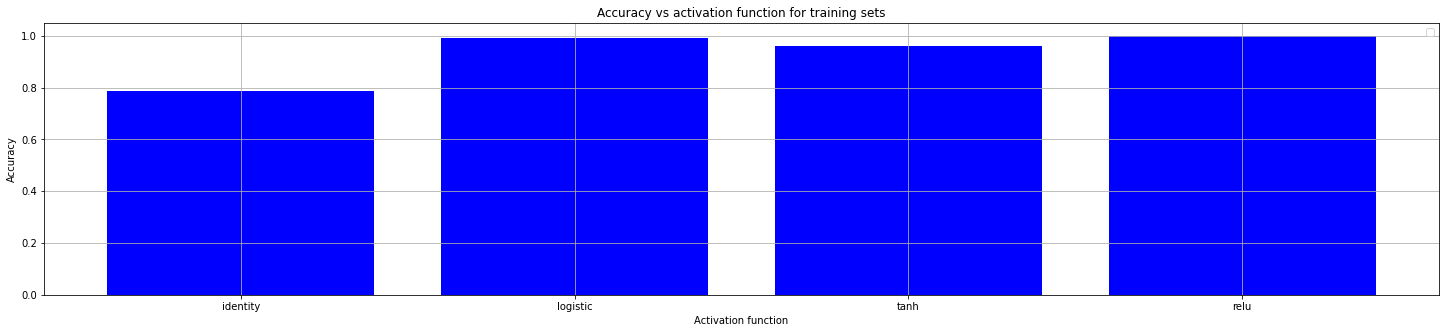

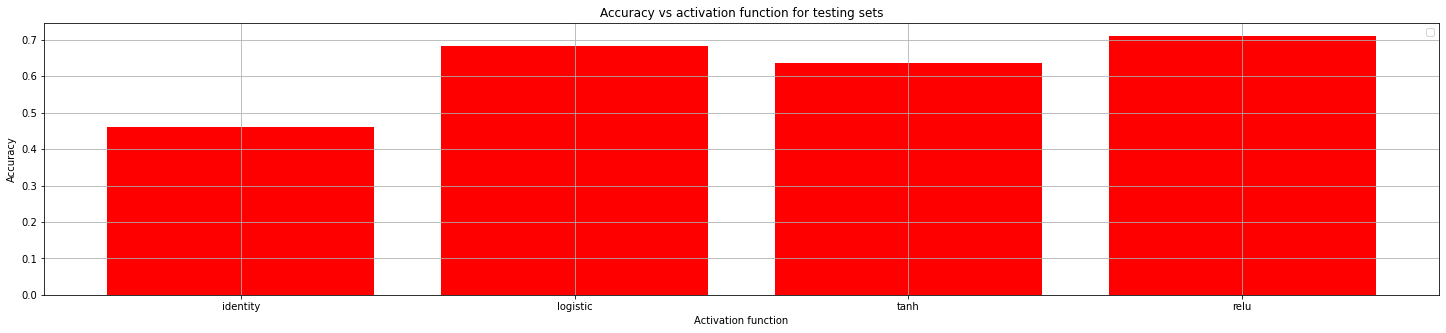

In [10]:
train_scores = [clf.score(pca_train, train_labels) for clf in clfs]
test_scores = [clf.score(pca_test, test_labels) for clf in clfs]

number = [i+1 for i in range(len(activationFunctions))]

fig, ax = plt.subplots(figsize=(25, 5))
ax.set_xlabel("Activation function")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs activation function for training sets")
ax.bar(number, train_scores, tick_label = activationFunctions, width = 0.8, color = ['blue']) 
ax.legend()
ax.grid()
plt.show()

fig, ax = plt.subplots(figsize=(25, 5))
ax.set_xlabel("Activation function")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs activation function for testing sets")
ax.bar(number, test_scores, tick_label = activationFunctions, width = 0.8, color = ['red'])
ax.legend()
ax.grid()
plt.show()

### Solver changes

Solvers considered :
- lbfgs : quasi-newton family optimization method
- sgd : updates weights with one sample at a time in gradient descent
- adam (by default): Adaptive moment (order 1 and 2) gradient descent $$Weights := Weights - \gamma \ \frac{V_{w}^{corr} }{\sqrt{S_{w}^{corr} + \epsilon}}\: \ , \ \: Bias := Bias - \gamma \ \frac{V_{b}^{corr}}{\sqrt{S_{b}^{corr} + \epsilon}}$$
(instead of simply: $ Weights := Weights - \gamma \ dW \ \ , \ \ Bias := Bias - \gamma \ dB$)

In [11]:
solvers = ['lbfgs', 'sgd', 'adam']

train_scores = []
test_scores = []

test_prec = []
test_rec= []
test_f1 = []
test_roc = []

for solver in solvers:
    sum_train = 0
    sum_test = 0
    
    precision = 0
    recall = 0
    f1 = 0
    roc = 0
    
    # avg accuracy on 5 trials
    for i in range(5):
        #print(i)
        clf = MLPClassifier(hidden_layer_sizes = hidden_layers_sets[-1], activation = 'relu', solver = solver, max_iter = 1500)
        clf.fit(pca_train, train_labels)
        sum_train += clf.score(pca_train, train_labels)
        sum_test += clf.score(pca_test, test_labels)
        
        y_pred = clf.predict(pca_test)
        y_prob = clf.predict_proba(pca_test)
        precision += precision_score(test_labels, y_pred, average = "weighted")
        recall += recall_score(test_labels, y_pred, average = "weighted")
        f1 +=f1_score(test_labels, y_pred, average = "weighted")
        roc += roc_auc_score(test_labels, y_prob, average = "weighted", multi_class = "ovr")
        
    train_scores.append(sum_train/(i+1))
    test_scores.append(sum_test/(i+1))
    
    if solver == 'adam':
        continue
    
    Architecture.append(hidden_layers_sets[-1])
    Solver.append(solver)
    Learning_rate.append(0.001)
    Activation.append("relu")
    Accuracy.append(sum_test/(i+1))
    Precision.append(precision/(i+1))
    Recall.append(precision/(i+1))
    F1.append(f1/(i+1))
    ROC.append(roc/(i+1))

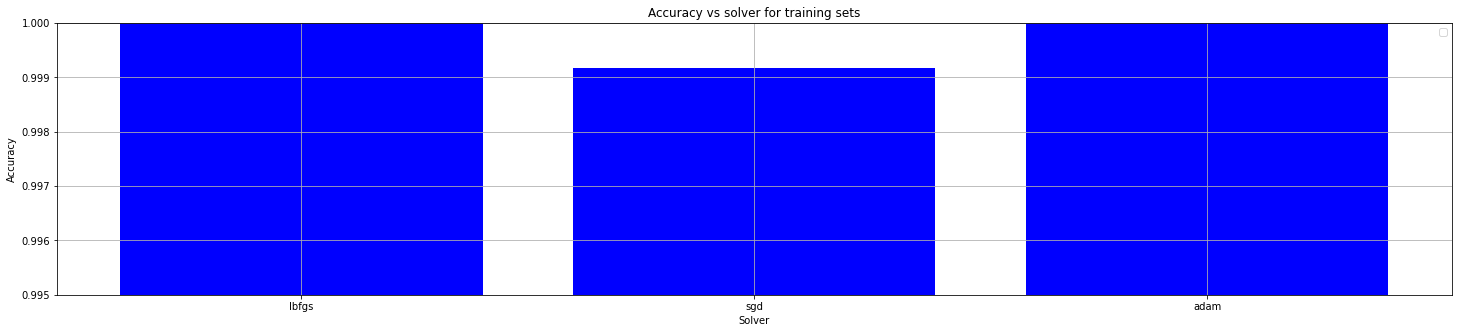

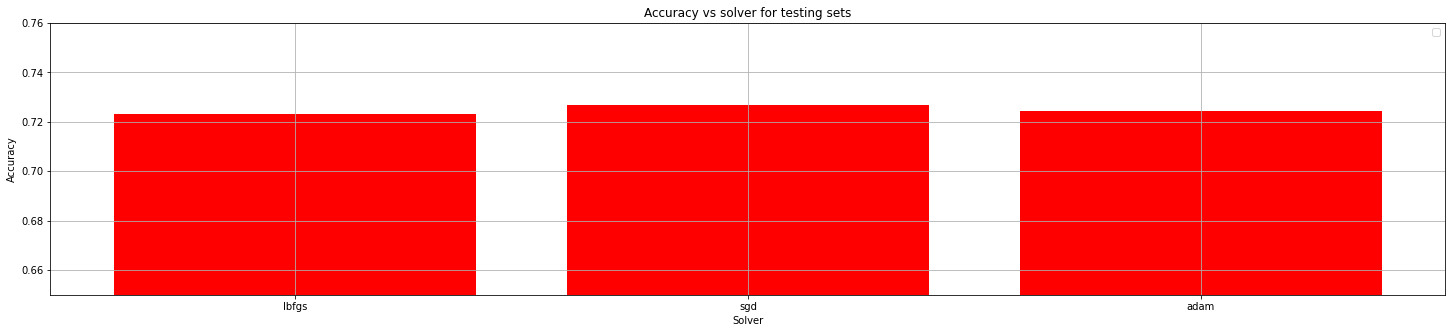

In [12]:
number = [i+1 for i in range(len(solvers))]

fig, ax = plt.subplots(figsize=(25, 5))
ax.set_xlabel("Solver")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs solver for training sets")
ax.bar(number, train_scores, tick_label = solvers, width = 0.8, color = ['blue']) 
ax.legend()
ax.grid()
ax.set_ylim(0.995, 1.0)
plt.show()

fig, ax = plt.subplots(figsize=(25, 5))
ax.set_xlabel("Solver")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs solver for testing sets")
ax.bar(number, test_scores, tick_label = solvers, width = 0.8, color = ['red'])
ax.legend()
ax.grid()
ax.set_ylim(0.65, 0.76)
plt.show()

Adam and lbfgs solvers are the most efficient ones

### Learning rate variations

- constant learning rate never changes
- invscaling (by default): $$\alpha := \frac{\alpha}{\sqrt{t}} $$
- adaptive : learning rate doesn't change if the network loss is decreasing. If two epochs don't succeed at decreasing the loss, then the learning rate is divided by 5

In [13]:
learning_rate = ['constant', 'invscaling', 'adaptive']
learning_rate_init = np.linspace(0.01, 0.001, 100)
# power_t = np.linspace(0.5, 2, 4)

clfs = []

for mode in learning_rate:
    
    clfs.append([])
    
#     for alpha in learning_rate_init:
    for i in tqdm (range (len(learning_rate_init)), desc="Loading..."): 
        clf = MLPClassifier(hidden_layer_sizes = hidden_layers_sets[-1], activation = 'relu', solver = 'adam', max_iter = 1500, learning_rate = mode, learning_rate_init = learning_rate_init[i], power_t = 0.2)
        clf.fit(pca_train, train_labels)
        clfs[-1].append(clf)

Loading...: 100%|██████████| 100/100 [05:04<00:00,  3.04s/it]


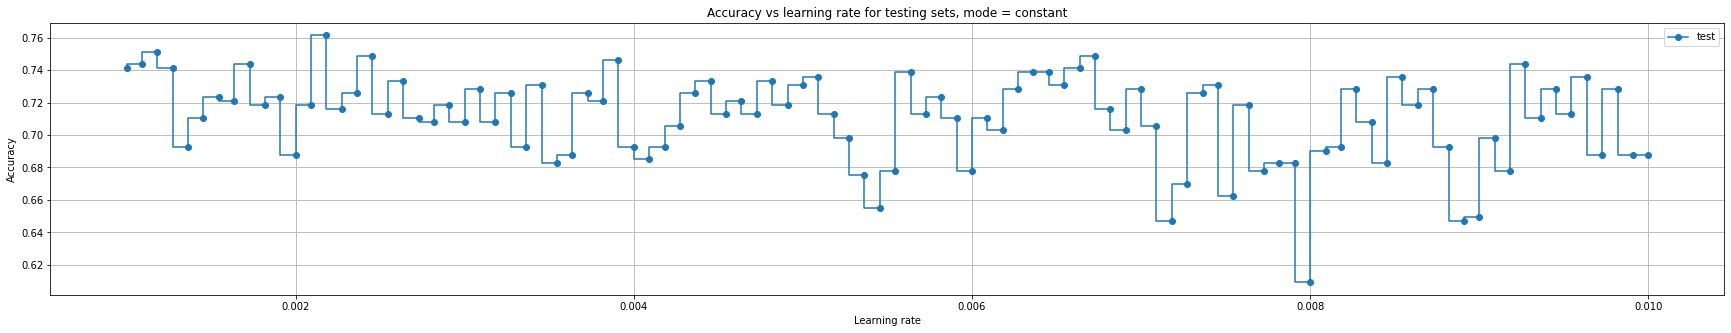

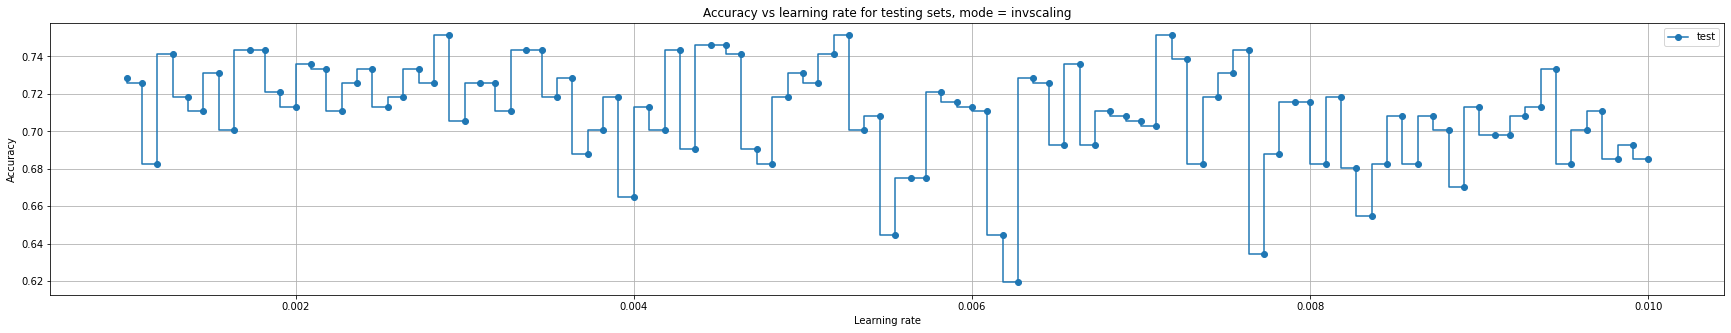

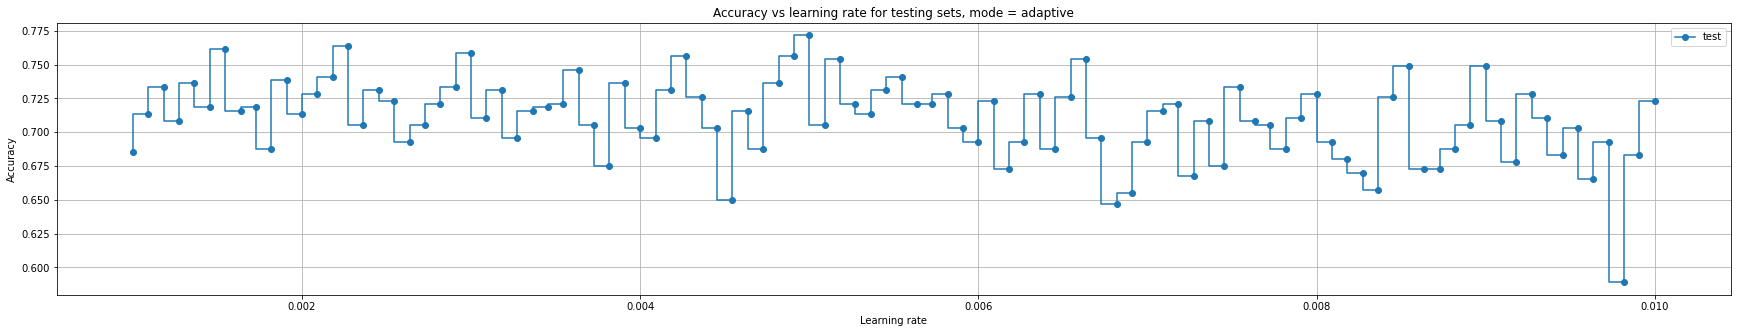

In [14]:
test_scores = []

for i in range(len(clfs)):
    
    test_scores.append([])
    test_scores[-1] = [clf.score(pca_test, test_labels) for clf in clfs[i]]

    fig, ax = plt.subplots(figsize=(30, 5))
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy vs learning rate for testing sets, mode = {}".format(learning_rate[i]))
    ax.plot(learning_rate_init, test_scores[-1], marker="o", label="test", drawstyle="steps-post")
    ax.legend()
    ax.grid()
    plt.show()

Better learning rates are at $10^{-3}$, not so much amelioration with different learning rate adapters.

## Table of results 

In [15]:
data = {'Architecture':  Architecture,
        'Solver': Solver,
        "Learning rate": Learning_rate,
        "Activation": Activation,
        'Accuracy' : Accuracy,
        'Weighted Precision': Precision,
        'Weighted Recall' : Recall,
        'Weighted F1 Score' : F1,
        'Weighted AUC' : ROC
        }

resume = pd.DataFrame(data)
pd.set_option('expand_frame_repr', False)

print(resume)

   Architecture Solver  Learning rate Activation  Accuracy  Weighted Precision  Weighted Recall  Weighted F1 Score  Weighted AUC
0         (20,)   adam          0.001       relu  0.713198            0.795080         0.713198           0.664328      0.839247
1      (20, 20)   adam          0.001       relu  0.743655            0.783751         0.743655           0.693870      0.838559
2  (20, 20, 20)   adam          0.001       relu  0.703046            0.753337         0.703046           0.657534      0.830124
3  (20, 20, 20)   adam          0.001   identity  0.459391            0.481681         0.459391           0.443033      0.694782
4  (20, 20, 20)   adam          0.001   logistic  0.682741            0.736205         0.682741           0.641124      0.822479
5  (20, 20, 20)   adam          0.001       tanh  0.637056            0.683275         0.637056           0.596745      0.800017
6  (20, 20, 20)  lbfgs          0.001       relu  0.723350            0.780490         0.780490  

# Multilayer Perceptron optimization

In [16]:
mlp_gs = MLPClassifier(max_iter=1500)
parameter_space = {
    'hidden_layer_sizes': [(40,), (40, 35,), (30, 20, 15), (20, 25, 15,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': np.linspace(0.001, 0.1, 10),
    'learning_rate': ['adaptive'],
}

from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(pca_train, train_labels)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1500), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': array([0.001, 0.012, 0.023, 0.034, 0.045, 0.056, 0.067, 0.078, 0.089,
       0.1  ]),
                         'hidden_layer_sizes': [(40,), (40, 35), (30, 20, 15),
                                                (20, 25, 15)],
                         'learning_rate': ['adaptive'], 'solver': ['adam']})

In [17]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.034, 'hidden_layer_sizes': (40, 35), 'learning_rate': 'adaptive', 'solver': 'adam'}


# Multilayer Perceptron on 3 data sets

## Set 1

In [18]:
ML = MLPClassifier(hidden_layer_sizes = hidden_layers_sets[-1], max_iter = 1500)
clf1 = ML.fit(pca_train, train_labels)

In [19]:
train_scores = clf1.score(pca_train, train_labels)
test_scores = clf1.score(pca_test, test_labels) 

print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

Training Accuracy...1.0
Test Accuracy...0.700507614213198


With the optimized MLP

In [20]:
train_scores = clf.score(pca_train, train_labels)
test_scores = clf.score(pca_test, test_labels) 

print("\n Grid Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")


 Grid Search CV
Training Accuracy...1.0
Test Accuracy...0.7106598984771574


## Set 2

In [21]:
from sklearn.model_selection import train_test_split

x_train_30, x_test_30, y_train_30, y_test_30 = train_test_split(pca_train, train_labels, test_size=0.30, random_state=42)

new_test_data = np.hstack((x_test_30, y_test_30[:,None]))

all_test_data = np.vstack((new_test_data, data_test))
x_test_30 = all_test_data[:,:-1]
y_test_30 = all_test_data[:,-1]

In [22]:
clf2 = ML.fit(x_train_30, y_train_30)

In [23]:
train_scores = clf2.score(x_train_30, y_train_30)
test_scores = clf2.score(x_test_30, y_test_30) 

print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

Training Accuracy...0.9995022399203584
Test Accuracy...0.7330677290836654


With the optimized MLP

In [24]:
train_scores = clf.score(x_train_30, y_train_30)
test_scores = clf.score(x_test_30, y_test_30) 

print("\n Grid Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")


 Grid Search CV
Training Accuracy...1.0
Test Accuracy...0.9091633466135458


## Set 3

In [25]:
from sklearn.model_selection import train_test_split

x_train_60, x_test_60, y_train_60, y_test_60 = train_test_split(pca_train, train_labels, test_size=0.60, random_state=42)

new_test_data = np.hstack((x_test_60, y_test_60[:,None]))

all_test_data = np.vstack((new_test_data, data_test))
x_test_60 = all_test_data[:,:-1]
y_test_60 = all_test_data[:,-1]

In [26]:
clf3 = ML.fit(x_train_60, y_train_60)

In [27]:
train_scores = clf3.score(x_train_60, y_train_60)
test_scores = clf3.score(x_test_60, y_test_60)  

print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

Training Accuracy...1.0
Test Accuracy...0.6748582230623819


With the optimized MLP

In [28]:
train_scores = clf.score(x_train_60, y_train_60)
test_scores = clf.score(x_test_60, y_test_60)  

print("\n Grid Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")


 Grid Search CV
Training Accuracy...1.0
Test Accuracy...0.946124763705104
